# Qaintellect variational quantum thermalizer (VQT) example

In this example, we implement the VQT algorithm by Verdon et al. to approximate a thermal state using a quantum circuit.

Reference:
- G. Verdon, J. Marks, S. Nanda, S. Leichenauer, J. Hidary: "Quantum Hamiltonian-based models and the variational quantum thermalizer algorithm", [arXiv:1910.02071](https://arxiv.org/abs/1910.02071) (2019)

In [1]:
using Qaintessent
using Qaintellect
using LinearAlgebra
using SparseArrays
using Flux
using IterTools: ncycle

In [2]:
# visualization
using Plots
using LaTeXStrings

In [3]:
using Random
Random.seed!(142);

## Physical model: Hamiltonian and thermal state

In [4]:
"""
Construct adjacency map for a cartesian Nx × Ny lattice.
"""
function lattice_adjacency_map(Nx::Integer, Ny::Integer; pbc=true)
    L = Nx * Ny
    adjacency = zeros(Int, (L, L))
    for j in 0:Ny-1
        j_next = (j+1) % Ny
        for i in 0:Nx-1
            i_next = (i+1) % Nx
            # nearest neighbors
            if (pbc || i_next > 0) adjacency[j*Nx + i + 1, j*Nx + i_next + 1] = 1; end
            if (pbc || j_next > 0) adjacency[j*Nx + i + 1, j_next*Nx + i + 1] = 1; end
        end
    end
    adjacency = adjacency + transpose(adjacency)
    # only 0 or 1 entries
    return (adjacency .≠ 0)
end

lattice_adjacency_map

In [5]:
adj = lattice_adjacency_map(2, 3; pbc=false)

6×6 BitMatrix:
 0  1  1  0  0  0
 1  0  0  1  0  0
 1  0  0  1  1  0
 0  1  1  0  0  1
 0  0  1  0  0  1
 0  0  0  1  1  0

In [6]:
# number of neighbors
sum(adj, dims=1)

1×6 Matrix{Int64}:
 2  2  3  3  2  2

In [7]:
# number of lattice sites
L = size(adj, 1)

6

In [8]:
"""
Construct horizontal adjacency map for a cartesian Nx × Ny lattice.
"""
function lattice_adjacency_map_horz(Nx::Integer, Ny::Integer; pbc=true)
    L = Nx * Ny
    adjacency = zeros(Int, (L, L))
    for j in 0:Ny-1
        for i in 0:Nx-1
            i_next = (i+1) % Nx
            # nearest neighbors along horizontal direction
            if (pbc || i_next > 0) adjacency[j*Nx + i + 1, j*Nx + i_next + 1] = 1; end
        end
    end
    adjacency = adjacency + transpose(adjacency)
    # only 0 or 1 entries
    return (adjacency .≠ 0)
end

"""
Construct vertical adjacency map for a cartesian Nx × Ny lattice.
"""
function lattice_adjacency_map_vert(Nx::Integer, Ny::Integer; pbc=true)
    L = Nx * Ny
    adjacency = zeros(Int, (L, L))
    for j in 0:Ny-1
        j_next = (j+1) % Ny
        for i in 0:Nx-1
            # nearest neighbors along vertical direction
            if (pbc || j_next > 0) adjacency[j*Nx + i + 1, j_next*Nx + i + 1] = 1; end
        end
    end
    adjacency = adjacency + transpose(adjacency)
    # only 0 or 1 entries
    return (adjacency .≠ 0)
end

lattice_adjacency_map_vert

In [9]:
adj_horz = lattice_adjacency_map_horz(2, 3; pbc=false)

6×6 BitMatrix:
 0  1  0  0  0  0
 1  0  0  0  0  0
 0  0  0  1  0  0
 0  0  1  0  0  0
 0  0  0  0  0  1
 0  0  0  0  1  0

In [10]:
adj_vert = lattice_adjacency_map_vert(2, 3; pbc=false)

6×6 BitMatrix:
 0  0  1  0  0  0
 0  0  0  1  0  0
 1  0  0  0  1  0
 0  1  0  0  0  1
 0  0  1  0  0  0
 0  0  0  1  0  0

In [11]:
# consistency check (results should be zero)
@show(norm(adj_horz + adj_vert - adj))
@show(norm(adj_horz .* adj_vert))

norm((adj_horz + adj_vert) - adj) = 0.0
norm(adj_horz .* adj_vert) = 0.0


0.0

In [12]:
"""
Identity map as sparse matrix with real-valued entries.
"""
sparse_identity(n) = sparse(1.0*I, n, n)

sparse_identity

In [13]:
"""
Construct a Heisenberg-type Hamiltonian as sparse matrix using site-dependent interaction strength, with nearest-neighbor interactions according to adjacency.
"""
function construct_hamiltonian(J::Array{<:Real,3})
    L = size(J, 3)
    @assert(size(J) == (3, L, L))

    # spin operators (Pauli matrices divided by 2)
    sigma12 = (0.5*sparse([0.  1.; 1.  0.]),
               0.5*sparse([0. -im; im  0.]),
               0.5*sparse([1.  0.; 0. -1.]))

    H = spzeros(Float64, 2^L, 2^L)

    # interaction terms
    for i in 1:L
        for j in i+1:L
            for k in 1:3
                # considering only entries in J for i < j
                if J[k, i, j] ≠ 0
                    H -= J[k, i, j] * real(kron(sparse_identity(2^(L-j)), sigma12[k], sparse_identity(2^(j-i-1)), sigma12[k], sparse_identity(2^(i-1))))
                end
            end
        end
    end

    return H
end

construct_hamiltonian

In [14]:
# model parameters
β = 2.6
Jx = 1.0
Jy = 0.6

0.6

In [15]:
# construct Hamiltonian
J = Jx * reshape(kron(adj_horz, [1, 1, 1]), (3, L, L)) + Jy * reshape(kron(adj_vert, [1, 1, 1]), (3, L, L))
H = construct_hamiltonian(J)
@assert(H ≈ H')
size(H)

(64, 64)

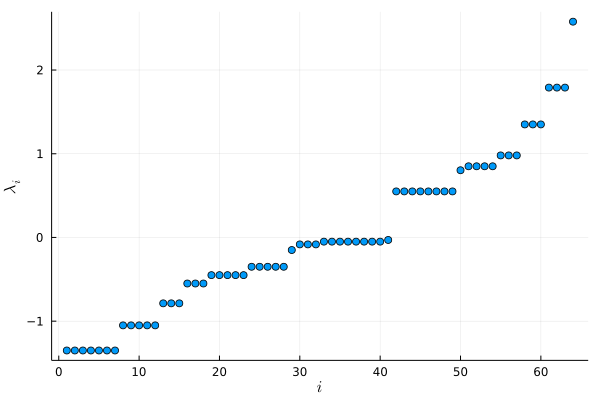

In [16]:
# show eigenvalues
fig = scatter(eigvals(Matrix(H)), xlabel=L"i", ylabel=L"\lambda_i", legend=false)

In [17]:
"""
Compute `-log(Z)`, with `Z` the partition function.
"""
thermal_logZ(βH::AbstractMatrix) = -log(tr(exp(-Matrix(βH))))

thermal_logZ

In [18]:
thermal_logZ(β*H)

-5.974568533204815

In [19]:
"""
Compute the thermal state `exp(-βH) / Z`, with `Z` the partition function.
"""
function thermal_state(βH::AbstractMatrix)
    σ = exp(-Matrix(βH))
    return σ / tr(σ)
end

thermal_state

In [20]:
σtherm = thermal_state(β*H)
typeof(σtherm)

Matrix{Float64} (alias for Array{Float64, 2})

In [21]:
# consistency check
tr(σtherm) - 1

-3.3306690738754696e-16

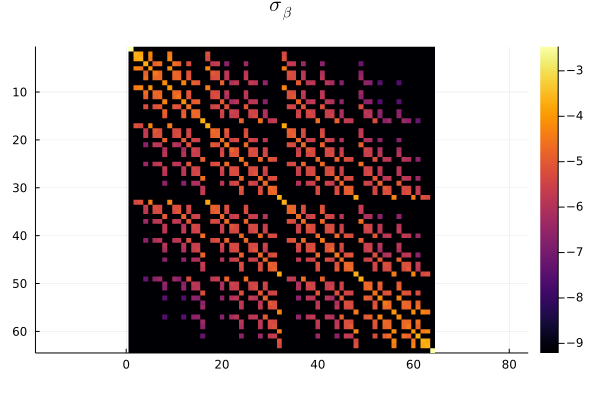

In [22]:
heatmap(log.(max.(σtherm, 1e-4)), title=L"\sigma_{\beta}", yflip=true, aspect_ratio=:equal)

## Parameterized quantum circuit and latent density matrix

In [23]:
"""
Construct a parametrized quantum layer consisting of single and two qubit rotation gates.
"""
function construct_parameterized_layer(L::Integer, istart::Integer)

    # TODO: take 2D adjacency into account? periodic boundary conditions?

    # local gates
    Uloc = [Moment([circuit_gate(i, RotationGate(0.05*π*randn(3))) for i in 1:L])]

    # interaction gates
    Uint = [
        Moment([circuit_gate(i, i+1, EntanglementXXGate(0.05π*randn())) for i in istart:2:L-1]),
        Moment([circuit_gate(i, i+1, EntanglementYYGate(0.05π*randn())) for i in istart:2:L-1]),
        Moment([circuit_gate(i, i+1, EntanglementZZGate(0.05π*randn())) for i in istart:2:L-1])]

    return vcat(Uloc, Uint)
end

construct_parameterized_layer

In [24]:
# parameterized quantum circuit gate chain
cgc = vcat(construct_parameterized_layer(L, 1), construct_parameterized_layer(L, 2), construct_parameterized_layer(L, 1));

In [25]:
# use Hamiltonian as measurement operator; note that H gets converted to a complex matrix here
Hmeas = MeasurementOperator(H, Tuple(1:L));

In [26]:
# parameterized quantum circuit
circ = Circuit{L}(cgc, [Hmeas])


    6 —[Rθ]———□—————□—————□————[Rθ]————————————————————[Rθ]———□—————□—————□———
              |     |     |                                   |     |     |   
    5 —[Rθ]———□—————□—————□————[Rθ]———□—————□—————□————[Rθ]———□—————□—————□———
                                      |     |     |                           
    4 —[Rθ]———□—————□—————□————[Rθ]———□—————□—————□————[Rθ]———□—————□—————□———
              |     |     |                                   |     |     |   
    3 —[Rθ]———□—————□—————□————[Rθ]———□—————□—————□————[Rθ]———□—————□—————□———
                                      |     |     |                           
    2 —[Rθ]———□—————□—————□————[Rθ]———□—————□—————□————[Rθ]———□—————□—————□———
              |     |     |                                   |     |     |   
    1 —[Rθ]———□—————□—————□————[Rθ]——————————————[Rθ]—————————□—————□—————□———


In [27]:
# use representation of density matrix in terms of Pauli matrices; cos(θ) is Bloch vector coefficient of Pauli-Z for each qubit
latent_density(θlist) = DensityMatrix(kron([[1, 0, 0, cos(θ)] for θ in θlist]...), length(θlist))

latent_density (generic function with 1 method)

In [28]:
# example
latent_density([π/3, 3π/8])

DensityMatrix(Float32[1.0, 0.0, 0.0, 0.38268343, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5, 0.0, 0.0, 0.19134171], 2, Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])

## Target ("loss") function and distance measures

In [29]:
"""
    xlogx(x::Number)

Compute `x * log(x)`, returning zero if `x` is zero. (Copied from StatsFuns.jl package.)
"""
function xlogx(x::Number)
    result = x * log(x)
    ifelse(iszero(x), zero(result), result)
end

xlogx

In [30]:
"""
    binary_entropy(p::Number)

Compute the binary entropy of `p` (natural logarithm).
"""
binary_entropy(p::Number) = -(xlogx(p) + xlogx(1 - p))

binary_entropy

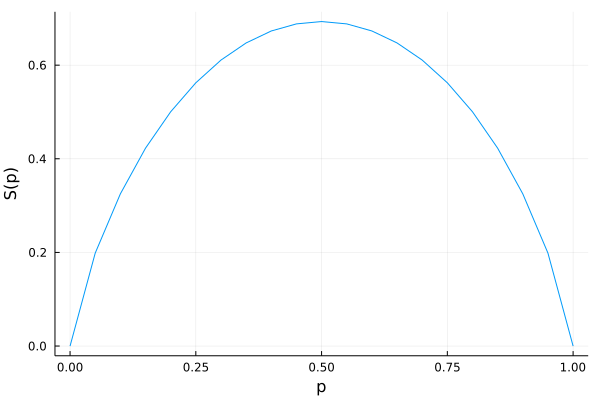

In [31]:
# visualize binary entropy
plot(0:0.05:1, binary_entropy.(0:0.05:1), xlabel="p", ylabel="S(p)", legend=false)

In [32]:
"""
Compute the von Neumann entropy of a density matrix `ρ`.
"""
neumann_entropy(ρ::AbstractMatrix) = -sum(xlogx.(real(eigvals(Matrix(ρ)))))

neumann_entropy

In [33]:
# target function: β tr[ρ H] - S(ρ), with ρ = U ρlatent U†
ftarget(θlist) = β * apply(latent_density(θlist), circ)[1] - sum(binary_entropy.((1 .+ cos.(θlist)) / 2))

ftarget (generic function with 1 method)

In [34]:
# initial random θ parameters, which are to be optimized
θopt = π/2 * (1 .+ 0.5*randn(L))

6-element Vector{Float64}:
 2.0318529706098656
 2.717020097618788
 0.9989301137413403
 1.827423480478452
 1.0620257822930346
 1.703306429578291

In [35]:
# example
ftarget(θopt)

-3.4045424285034054

In [36]:
# consistency check
neumann_entropy(matrix(apply(latent_density(θopt), cgc))) - sum(binary_entropy.((1 .+ cos.(θopt)) / 2))

-7.304052225265423e-7

In [37]:
"""
Trace distance to target density matrix `σ`.
"""
trdistance(θlist, σ) = 0.5 * opnorm(matrix(apply(latent_density(θlist), cgc)) - σ, 1)

trdistance

In [38]:
# example
trdistance(θopt, σtherm)

0.1580962285190922

## Perform optimization

In [39]:
# gather parameters from circuit
paras = Flux.params(circ)
# measurement operator (Hamiltonian) not "trainable" here
delete!(paras, circ.meas[1].operator)
# add θ parameters
Flux.params!(paras, θopt)
paras

Params([Float32[0.040983554, 0.40255836, 0.052698717], Float32[-0.18232352, -0.090331964, -0.23458481], Float32[-0.05776069, 0.26747993, -0.082058355], Float32[0.20918545, 0.021930521, -0.037663504], Float32[0.07177894, 0.4778533, 0.031728465], Float32[-0.05435562, 0.09969929, 0.12545373], Float32[0.06536225], Float32[0.06538801], Float32[-0.0025789517], Float32[0.07517289], Float32[-0.20450656], Float32[0.15270717], Float32[0.24226269], Float32[0.12700617], Float32[0.1032697], Float32[0.15523788, 0.25014, 0.023242695], Float32[-0.23708455, 0.37828633, 0.06864064], Float32[-0.29249632, -0.1975691, 0.27519658], Float32[0.20765826, 0.12546287, 0.07934507], Float32[0.025782868, -0.016668057, -0.0030892137], Float32[0.019070923, -0.2959702, -0.122801594], Float32[-0.19996083], Float32[0.16453618], Float32[-0.1413626], Float32[0.10085954], Float32[-0.38797143], Float32[-0.42302066], Float32[-0.1435571, -0.06259261, -0.09940565], Float32[0.05932232, 0.14004058, 0.14094594], Float32[-0.122823

In [40]:
# there is not actually any input data for training
data = ncycle([()], 200)

# define optimizer
opt = RMSProp(0.05)

# define evaluation function
evalcb() = println("ftarget(θopt): $(ftarget(θopt)), reference: $(thermal_logZ(β*H)); trdistance(θopt, σtherm): $(trdistance(θopt, σtherm))")

# perform optimization
Flux.train!(() -> ftarget(θopt), paras, data, opt, cb=Flux.throttle(evalcb, 4.0))

ftarget(θopt): -3.8078123277395046, reference: -5.974568533204815; trdistance(θopt, σtherm): 0.09304344968001448
ftarget(θopt): -5.062739362531575, reference: -5.974568533204815; trdistance(θopt, σtherm): 0.09923470591479783
ftarget(θopt): -5.0783605590405445, reference: -5.974568533204815; trdistance(θopt, σtherm): 0.10650343740452659
ftarget(θopt): -5.079034989199891, reference: -5.974568533204815; trdistance(θopt, σtherm): 0.10340607401604444
ftarget(θopt): -5.0661708497557285, reference: -5.974568533204815; trdistance(θopt, σtherm): 0.09890088655326984
ftarget(θopt): -5.089324888199436, reference: -5.974568533204815; trdistance(θopt, σtherm): 0.09929270270215339
ftarget(θopt): -5.100506874880439, reference: -5.974568533204815; trdistance(θopt, σtherm): 0.09389422891624996
ftarget(θopt): -5.088653536256394, reference: -5.974568533204815; trdistance(θopt, σtherm): 0.10653916776205019
ftarget(θopt): -5.101507146557374, reference: -5.974568533204815; trdistance(θopt, σtherm): 0.1058623

In [41]:
# seems like the Ansatz is too restricted, or the optimization trapped in a local minimum, to further descrease the distance
trdistance(θopt, σtherm)

0.09954551276510074

In [42]:
# optimized variational density matrix
ρopt = apply(latent_density(θopt), cgc)

DensityMatrix(Float32[1.0, -0.2574142, -0.22260246, -0.046752844, -0.27132773, 0.3369535, 0.09101708, -0.030676048, -0.11435073, -0.001410556  …  0.0002822072, -0.00055167964, -0.0011726355, 0.00021294449, 0.0010414027, -0.00018670928, -0.00046235285, 0.00030048873, 0.00029659903, 0.00033298373], 6, Float32[2.2f-44, 0.0, 1.7f-44, 0.0, 2.0f-44, 0.0, 2.1f-44, 0.0, 1.1f-44, 0.0  …  -1.0842022f-19, 1.0699999, 0.0, 0.0, -1.0842022f-19, 1.0699999, 0.0, 0.0, -1.0842022f-19, 1.0699999])

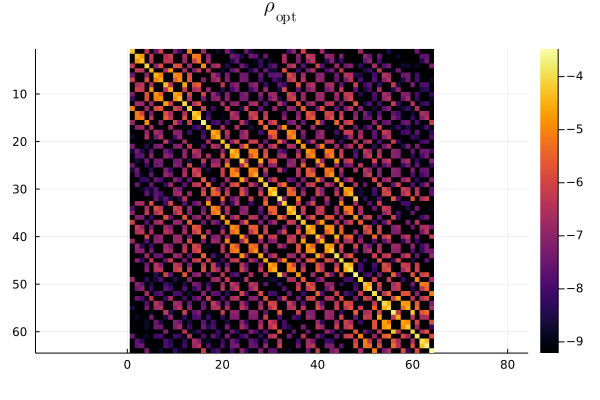

In [43]:
# visualize optimized density matrix
heatmap(log.(max.(real(matrix(ρopt)), 1e-4)), title=L"\rho_{\mathrm{opt}}", yflip=true, aspect_ratio=:equal)